<a href="https://colab.research.google.com/github/abhishekmanglaa/health-inspections-analysis-python/blob/main/health_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Data in Prince George's County

# **Analysis of Health Inspections Across Prince George's County**

In [6]:
#importing the libraries

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part (1-a)
## I'm using the 'Carry-out', 'Fast Food', 'Ice Cream', 'Bakery/Catering', 'Restaurant', 'Bar/Tavern/Lounge', 'Bakery', 'Coffee Shop', 'Cafeteria', 'Deli', 'Seafood', 'Fast Food - Chain', 'Full Service/Catering', 'Buffet', 'Pizza', 'Fast Food - Local', '@Full Service', 'Diner', 'Donut', 'B & B'
## As the valid restaurants

In [5]:
#Reading the Dataframe
healthDF = pd.read_csv('/content/drive/My Drive/Data/HW7_Food Inspection.csv')
healthDF.head()

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,Food_from_approved_source,Food_protected_from_contamination,Ill_workers_restricted,Proper_hand_washing,Cooling_time_and_temperature,Cold_holding_temperature,Hot_holding_temperature,Cooking_time_and_temperature,Reheating_time_and_temperature,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location,Zip Codes
0,8176,LAUREL DUTCH MARKET - SAMMIE'S PRODUCE,Carry-out,09/05/2019 12:00:00 AM,Critical Violations observed,LAUREL,MD,20707.0,9701 FORT MEADE RD,------,In Compliance,Out of Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Monitoring,Samuel Stoltzfus,Food Establishments,POINT (-76.838165 39.095491),15996.0
1,14622,JERSEY MIKE'S SUBS,Fast Food,09/06/2019 12:00:00 AM,Critical Violations observed,Riverdale,MD,20737.0,6761 45th ST,------,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Out of Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Re-inspection,DANIEL MALAMIS,Food Establishments,NaN,NaN
2,7273,ACCOKEEK ACADEMY,Public School,09/09/2019 12:00:00 AM,Non-Compliant - Violations Observed,ACCOKEEK,MD,20607.0,14400 BERRY RD,------,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Comprehensive,MARK FOSSETT,Food Establishments,POINT (-76.980676 38.687531),8834.0
3,2103,PAPA JOHNS 728,Carry-out,09/05/2019 12:00:00 AM,Compliant - No Health Risk,BOWIE,MD,20715.0,6852 RACE TRACK RD,------,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Re-inspection,Annie Berkovicz,Food Establishments,POINT (-76.729269 38.983881),16435.0
4,347,COLUMBIA PARK ELEMENTARY SCHOOL,Public School,09/05/2019 12:00:00 AM,Critical Violations observed,LANDOVER,MD,20785.0,1901 KENT VILLAGE DR,------,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Out of Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,In Compliance,Out of Compliance,In Compliance,Comprehensive,MARK FOSSETT,Food Establishments,POINT (-76.88767 38.91584),31451.0


In [7]:
#Unique values from the Category column
#print(healthDF.Category.unique())
validRestaurants = ['Carry-out', 'Fast Food', 'Ice Cream', 'Bakery/Catering', 
                    'Restaurant', 'Bar/Tavern/Lounge', 'Bakery', 'Coffee Shop',
                    'Cafeteria', 'Deli', 'Seafood', 'Fast Food - Chain', 'Full Service/Catering',
                   'Buffet', 'Pizza', 'Fast Food - Local', '@Full Service', 'Diner', 'Donut',
                    'B & B']

def checkRestaurant(name):
  if str(name) in validRestaurants:
    return 1
  return 0


healthDF['Restaurant'] = healthDF.Category.apply(checkRestaurant)

## Part 1-b 

In [8]:
healthDF['Inspection_date'] = pd.to_datetime(healthDF['Inspection_date'], format='%m/%d/%Y %H:%M:%S %p')
healthDF['Year'] = (pd.DatetimeIndex(healthDF['Inspection_date'])).year
healthDF['Month'] = pd.DatetimeIndex(healthDF['Inspection_date']).month
healthDF['Month_Year'] = (healthDF['Inspection_date']).dt.strftime('%Y-%m')

## Part 1-c

In [9]:
#Def a function for creating dummy from the columns
def inComplianceDummy(x):
  if(str(x) == 'In Compliance'):
    return 0
  elif(str(x) == 'Out of Compliance'):
    return 1
  else:
    return np.nan

In [10]:
healthDF.columns

Index(['Establishment_id', 'Name', 'Category', 'Inspection_date',
       'Inspection_results', 'City', 'State', 'Zip', 'Address_line_1',
       'Address_line_2', 'Food_from_approved_source',
       'Food_protected_from_contamination', 'Ill_workers_restricted',
       'Proper_hand_washing', 'Cooling_time_and_temperature',
       'Cold_holding_temperature', 'Hot_holding_temperature',
       'Cooking_time_and_temperature', 'Reheating_time_and_temperature',
       'Hot_and_cold_running_water_provided', 'Proper_sewage_disposal',
       'No_bare_hand_contact', 'Adequate_hand_washing_facilities',
       'Rodent_and_insects', 'Food_contact_surfaces_and_equipment',
       'Inspection_type', 'Owner', 'Type', 'Location', 'Zip Codes',
       'Restaurant', 'Year', 'Month', 'Month_Year'],
      dtype='object')

In [11]:
listOfComlianceColumns = ['Food_from_approved_source',
       'Food_protected_from_contamination', 'Ill_workers_restricted',
       'Proper_hand_washing', 'Cooling_time_and_temperature',
       'Cold_holding_temperature', 'Hot_holding_temperature',
       'Cooking_time_and_temperature', 'Reheating_time_and_temperature',
       'Hot_and_cold_running_water_provided', 'Proper_sewage_disposal',
       'No_bare_hand_contact', 'Adequate_hand_washing_facilities',
       'Rodent_and_insects', 'Food_contact_surfaces_and_equipment']

In [12]:
#Applying the function to the list of columns
for col in listOfComlianceColumns:
  healthDF[col] = (healthDF[col]).apply(inComplianceDummy)

## Part 1-d

In [13]:
#Adding all the columns
healthDF['Number_of_Violations'] = healthDF.loc[:,listOfComlianceColumns].sum(axis = 1)

In [14]:
healthDF.head()

,Establishment_id,Name,Category,Inspection_date,Inspection_results,City,State,Zip,Address_line_1,Address_line_2,Food_from_approved_source,Food_protected_from_contamination,Ill_workers_restricted,Proper_hand_washing,Cooling_time_and_temperature,Cold_holding_temperature,Hot_holding_temperature,Cooking_time_and_temperature,Reheating_time_and_temperature,Hot_and_cold_running_water_provided,Proper_sewage_disposal,No_bare_hand_contact,Adequate_hand_washing_facilities,Rodent_and_insects,Food_contact_surfaces_and_equipment,Inspection_type,Owner,Type,Location,Zip Codes,Restaurant,Year,Month,Month_Year,Number_of_Violations
0,8176,LAUREL DUTCH MARKET - SAMMIE'S PRODUCE,Carry-out,2019-09-05 12:00:00,Critical Violations observed,LAUREL,MD,20707.0,9701 FORT MEADE RD,------,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Monitoring,Samuel Stoltzfus,Food Establishments,POINT (-76.838165 39.095491),15996.0,1,2019,9,2019-09,1
1,14622,JERSEY MIKE'S SUBS,Fast Food,2019-09-06 12:00:00,Critical Violations observed,Riverdale,MD,20737.0,6761 45th ST,------,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Re-inspection,DANIEL MALAMIS,Food Establishments,NaN,NaN,1,2019,9,2019-09,1
2,7273,ACCOKEEK ACADEMY,Public School,2019-09-09 12:00:00,Non-Compliant - Violations Observed,ACCOKEEK,MD,20607.0,14400 BERRY RD,------,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Comprehensive,MARK FOSSETT,Food Establishments,POINT (-76.980676 38.687531),8834.0,0,2019,9,2019-09,0
3,2103,PAPA JOHNS 728,Carry-out,2019-09-05 12:00:00,Compliant - No Health Risk,BOWIE,MD,20715.0,6852 RACE TRACK RD,------,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Re-inspection,Annie Berkovicz,Food Establishments,POINT (-76.729269 38.983881),16435.0,1,2019,9,2019-09,0
4,347,COLUMBIA PARK ELEMENTARY SCHOOL,Public School,2019-09-05 12:00:00,Critical Violations observed,LANDOVER,MD,20785.0,1901 KENT VILLAGE DR,------,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,Comprehensive,MARK FOSSETT,Food Establishments,POINT (-76.88767 38.91584),31451.0,0,2019,9,2019-09,2


## Part 1-e

In [15]:
#Selecting the columns 
healthPivotDF = healthDF.loc[:, ['Establishment_id', 'Category', 'Inspection_date', 'Number_of_Violations']]

In [16]:
#Making a dictionary and saving the category corresponding to each establishment_id
categoryDict = {}
for id in healthPivotDF.Establishment_id:
  category = healthPivotDF[healthPivotDF['Establishment_id'] == id].sort_values(by = ['Inspection_date']).iloc[0,1]
  categoryDict[id] = category

In [17]:
#Overwritting the duplicates
for i in range(len(healthPivotDF)):
  healthPivotDF.iloc[i,1] = categoryDict[healthPivotDF.iloc[i,0]]

In [18]:
#Getting the nth inspection using group
healthPivotDF['Inspection_Number'] = 'Inspection_' + (healthPivotDF.groupby('Establishment_id').cumcount() + 1).astype(str)

In [19]:
#Using pivot to convert to wide format
healthPivotDF.pivot(index='Establishment_id', 
                    columns='Inspection_Number', 
                    values='Number_of_Violations')

Inspection_Number,Inspection_1,Inspection_10,Inspection_11,Inspection_12,Inspection_13,Inspection_14,Inspection_15,Inspection_16,Inspection_17,Inspection_18,Inspection_19,Inspection_2,Inspection_20,Inspection_21,Inspection_22,Inspection_23,Inspection_24,Inspection_25,Inspection_26,Inspection_27,Inspection_28,Inspection_29,Inspection_3,Inspection_30,Inspection_31,Inspection_32,Inspection_33,Inspection_34,Inspection_35,Inspection_36,Inspection_37,Inspection_38,Inspection_39,Inspection_4,Inspection_40,Inspection_41,Inspection_42,Inspection_43,Inspection_44,Inspection_45,Inspection_46,Inspection_47,Inspection_48,Inspection_49,Inspection_5,Inspection_50,Inspection_51,Inspection_52,Inspection_53,Inspection_54,Inspection_55,Inspection_56,Inspection_57,Inspection_58,Inspection_59,Inspection_6,Inspection_7,Inspection_8,Inspection_9
Establishment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0
3,0.0,0.0,2.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0
4,1.0,0.0,1.0,1.0,0.0,4.0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16018,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Part 2-a

In [20]:
#Getting the most common type of violation
(healthDF.loc[:, listOfComlianceColumns]
 .sum(axis = 0)
 .sort_values(ascending = False))

Cold_holding_temperature               6725
Food_contact_surfaces_and_equipment    6044
Rodent_and_insects                     5816
Hot_holding_temperature                3435
Food_protected_from_contamination      1368
Proper_hand_washing                    1248
Cooling_time_and_temperature            338
Hot_and_cold_running_water_provided     229
Cooking_time_and_temperature            157
Reheating_time_and_temperature          138
Food_from_approved_source               103
Proper_sewage_disposal                   80
Ill_workers_restricted                   19
Adequate_hand_washing_facilities          0
No_bare_hand_contact                      0
dtype: int64

## Part 3-a

In [21]:
#getting the resturants 
violationDF = (healthDF[healthDF['Restaurant'] == 1]
 .loc[:, listOfComlianceColumns].sum(axis = 0))

Text(0.5, 1.0, 'Most Frequent Violations')

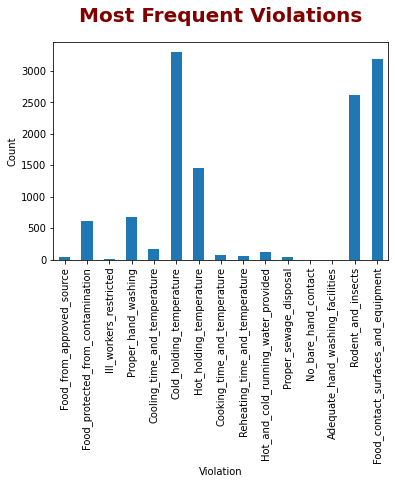

In [22]:
#Plotting the graph
axis = violationDF.plot.bar()
axis.set_xlabel('Violation')
axis.set_ylabel('Count')
axis.set_title('Most Frequent Violations', fontdict={'fontsize': 20, 'fontweight': 700, 'color': 'maroon'}, pad=20)

## Part 3-b

In [23]:
#Getting the data
restaurantDF = (healthDF[(healthDF['Restaurant'] == 1) & (healthDF['Number_of_Violations'] >0)]).groupby(by = ['Month_Year']).count()
restaurantDF = pd.DataFrame({ 'date': restaurantDF.index, 'est': restaurantDF.Establishment_id})
restaurantDF['est'] = (restaurantDF['est'] / len(healthDF))*100

Text(0, 0.5, '%Of restaurants with violations')

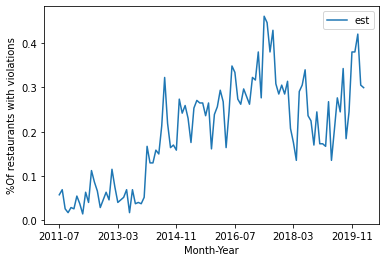

In [24]:
axes = restaurantDF.plot()
axes.set_xlabel('Month-Year')
axes.set_ylabel('%Of restaurants with violations')

In [25]:
## Inspections seem to be getting harder and harder with with time as we see more % of restaurants with a violation.
## There seem to be less number of violations around March

## Part 3-c

In [26]:
# defining regex for getting latitude and longitude
def getLongitude(s):
  s = str(s)
  match = re.findall(r'-?\d+\.?\d*', s)
  if(match!= []):
    return match[0]

def getLatitude(s):
  s = str(s)
  match = re.findall(r'-?\d+\.?\d*', s)
  if(match!= []):
    return match[1]

In [27]:
#Applying the function to get lat, lon
healthDF['Longitude'] = healthDF.Location.apply(getLongitude)
healthDF['Latitude'] = healthDF.Location.apply(getLatitude)

In [28]:
#Filtering for restaurants
mapDF = healthDF[healthDF['Restaurant'] == 1]

In [29]:
#getting the mapbox token
mapbox_access_token = 'pk.eyJ1IjoiYWJoaXNoZWttYW5nbGEiLCJhIjoiY2s5aG9ibnFiMTBxZzNtb2JvcHFvMTl2NSJ9.hwI010pPFFbKdQaUM0zjcg'

In [30]:
class_map_data = go.Scattermapbox(
        lon = mapDF['Longitude'],
        lat = mapDF['Latitude'],
        text = mapDF['Name'],
        hoverinfo='text',
        mode = 'markers',
        marker = dict(
                    color = 'red',
                    symbol = 'circle',
                    opacity = .5
                )
)

class_map_layout = go.Layout(
        title = 'Restaurants',
        mapbox=go.layout.Mapbox(
            accesstoken=mapbox_access_token,
            zoom=1
        )
    )

class_map = go.Figure(data=class_map_data, layout=class_map_layout)
class_map.show()